In [8]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import bootstrap
from scipy.stats import levene
import pingouin as pg
from tqdm.auto import tqdm


In [9]:
sns.set(
    font_scale = 1, #Размер шрифта
    style      = "whitegrid", # общий вид графиков
    rc         = {'figure.figsize':(20,8)} # размер фигуры
)


Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [10]:
reg_data_df = pd.read_csv('/Users/georgiisilakov/Desktop/Final Project/problem1-reg_data.csv',sep=';')
auth_data_df = pd.read_csv('/Users/georgiisilakov/Desktop/Final Project/problem1-auth_data.csv', sep = ';')


Посмотрим на количество уникальх юзеров в датасетах

In [11]:
reg_data_df['uid'].nunique()


1000000

In [12]:
auth_data_df['uid'].nunique()


1000000

Количество уникальных пользователей совпадает

Проверим на наличие пустых строк и формат данных

In [13]:
reg_data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [14]:
auth_data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Пустых строк в данных нет

Напишем функцию:

In [15]:
def retention(reg_data_df, auth_data_df, min_date, max_date):
    #Первым делом переведем колонки с датой в формат datetime
    reg_data_df['reg_ts'] = pd.to_datetime(reg_data_df['reg_ts'], unit='s')
    auth_data_df['auth_ts'] = pd.to_datetime(auth_data_df['auth_ts'], unit='s')
    #Так как расчет будет по дням - уберем информацию со временем
    reg_data_df['reg_ts'] = reg_data_df['reg_ts'].dt.strftime('%Y-%m-%d')
    auth_data_df['auth_ts'] = auth_data_df['auth_ts'].dt.strftime('%Y-%m-%d')
    #Снова переведем в формат datetime, чтобы можно было работать с датой
    reg_data_df['reg_ts'] = pd.to_datetime(reg_data_df['reg_ts'])
    auth_data_df['auth_ts'] = pd.to_datetime(auth_data_df['auth_ts'])


    # Теперь можно соединять датафреймы с указанием условий по минимальной и максимальной дате, которые будут выставляться в аргументах функции для расчета нужного периода

    reg_data_df = reg_data_df.query("reg_ts >= @min_date") #ссылки на фильтры при применении функции
    auth_data_df = auth_data_df.query("auth_ts <= @max_date") #ссылки на фильтры при применении функции
    df = reg_data_df.merge(auth_data_df, how = 'left', on = 'uid')

    #Строим сводник с датой регистрации, датой посещений и количеством уникальных пользователей
    retention = (df.groupby(['reg_ts','auth_ts'], as_index=False)
        .agg({'uid' : 'nunique'})
        .rename(columns = {'uid' : 'count_unique_custumers'}))

    #Добавляем в сводник колонку с разницей по дням между посещениями и регистрацией
    retention['retention'] = (retention['auth_ts'] - retention['reg_ts']).dt.days

    #Для удобного просмотра строим pivot_table, в индексах у нас будет дата регистрации , в колонках - retention по дням, значениями будут уникальные пользователи
    #nan для удобства заменим на 0

    cohort = retention.pivot_table(index = 'reg_ts', columns = 'retention', values='count_unique_custumers')
    cohort_size = cohort.iloc[:,0]
    retention_matrix = cohort.divide(cohort_size, axis = 0).fillna(0)

    sns.heatmap(retention_matrix,
            annot=True,
            fmt='.2%',
            center=0,
            vmin=0.0,
            vmax=0.01,
            cmap= 'coolwarm',
           linewidths=3, linecolor='black')


Посчитаем retention за первые две недели октября 2019 года

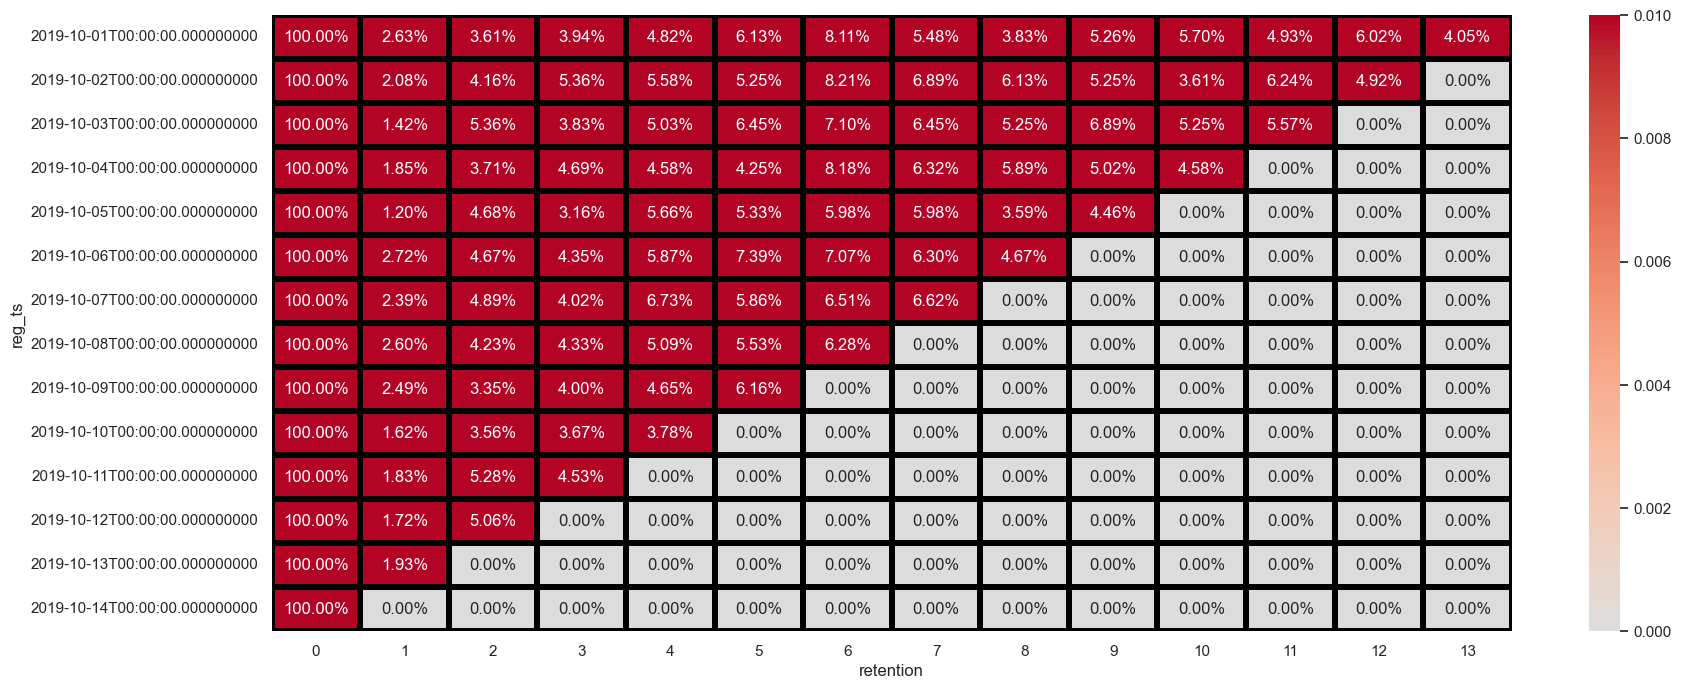

In [16]:
retention(reg_data_df, auth_data_df, min_date = datetime.date(2019, 10, 1 ), max_date = datetime.date(2019, 10, 14))
#В аргументах min_date и max_date выставляем нужный нам период, тогда в датафреймах еще на этапе объединения в данных будет отобран заданный период


Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 

Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [17]:
df = pd.read_csv('/Users/georgiisilakov/Desktop/Final Project/Проект_1_Задание_2.csv', sep = ';')


In [18]:
df.head()


,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [19]:
#Посмотрим есть ли пустые значения
df.isna().mean()


user_id      0.0
revenue      0.0
testgroup    0.0
dtype: float64

In [20]:
df.groupby('user_id').agg({'user_id' : 'nunique'}).sum()


user_id    404770
dtype: int64

Количество уникальных пользователей соответствует числу строк в данных, значит каждый клиент встречается в данных только один раз

- Группа а - контрольная
- Группа b - тестовая

В условии задания сказано, что ARPU в тестовой группе выше, чем в контрольной на 5% 
Проверим так ли это:

In [21]:
ARPU_group_a = df.query("testgroup == 'a'")['revenue'].sum()/df.query("testgroup == 'a'")['revenue'].count()


In [22]:
ARPU_group_b = df.query("testgroup == 'b'")['revenue'].sum()/df.query("testgroup == 'b'")['revenue'].count()


In [23]:
((ARPU_group_b/ARPU_group_a-1)*100).round(0)


5.0

Действительно, ARPU в тестовой группе выше чем в контрольной на 5% 

Посчитаем общее число клиентов, выручку, количество платящих клиентов, средний чек и конверсию по группам:

In [24]:
cnt_client=df.groupby('testgroup')['revenue'].agg(['count', 'sum'])
t = df.query('revenue != 0').groupby('testgroup',as_index=False)['revenue'].agg(['count'])
t = t.rename(columns={'count' : 'number_paying_customers'})
cnt_client = cnt_client.merge(t, how='left', on = 'testgroup').reset_index()
cnt_client['average_check'] = (cnt_client['sum'] / cnt_client['number_paying_customers']).round()
cnt_client['CR'] = cnt_client['number_paying_customers'] / cnt_client['count'] * 100


In [25]:
cnt_client = cnt_client.rename(columns = {'count' : 'number_of_customers', 'sum' : 'revenue'})
cnt_client


,testgroup,number_of_customers,revenue,number_paying_customers,average_check,CR
0,a,202103,5136189,1928,2664.0,0.953969
1,b,202667,5421603,1805,3004.0,0.890624


Видим, что конверсия выше в контрольной группе - 0.95, против 0.89 в тестовой группе

Общее число пользователей в группах отличается незначительно

Посмотрим на распределение выручки в группах:

<Axes: >

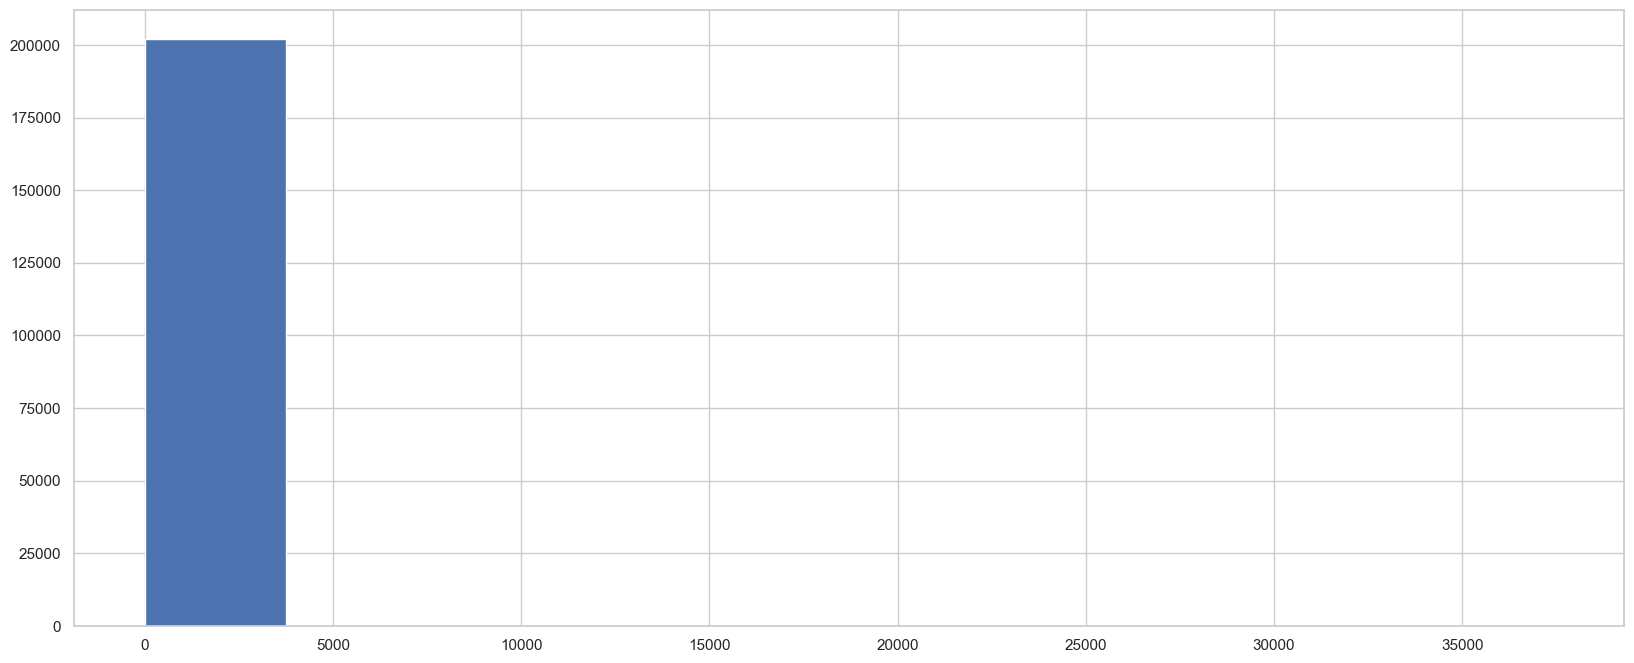

In [26]:
df.query("testgroup == 'a'")['revenue'].hist()


<Axes: >

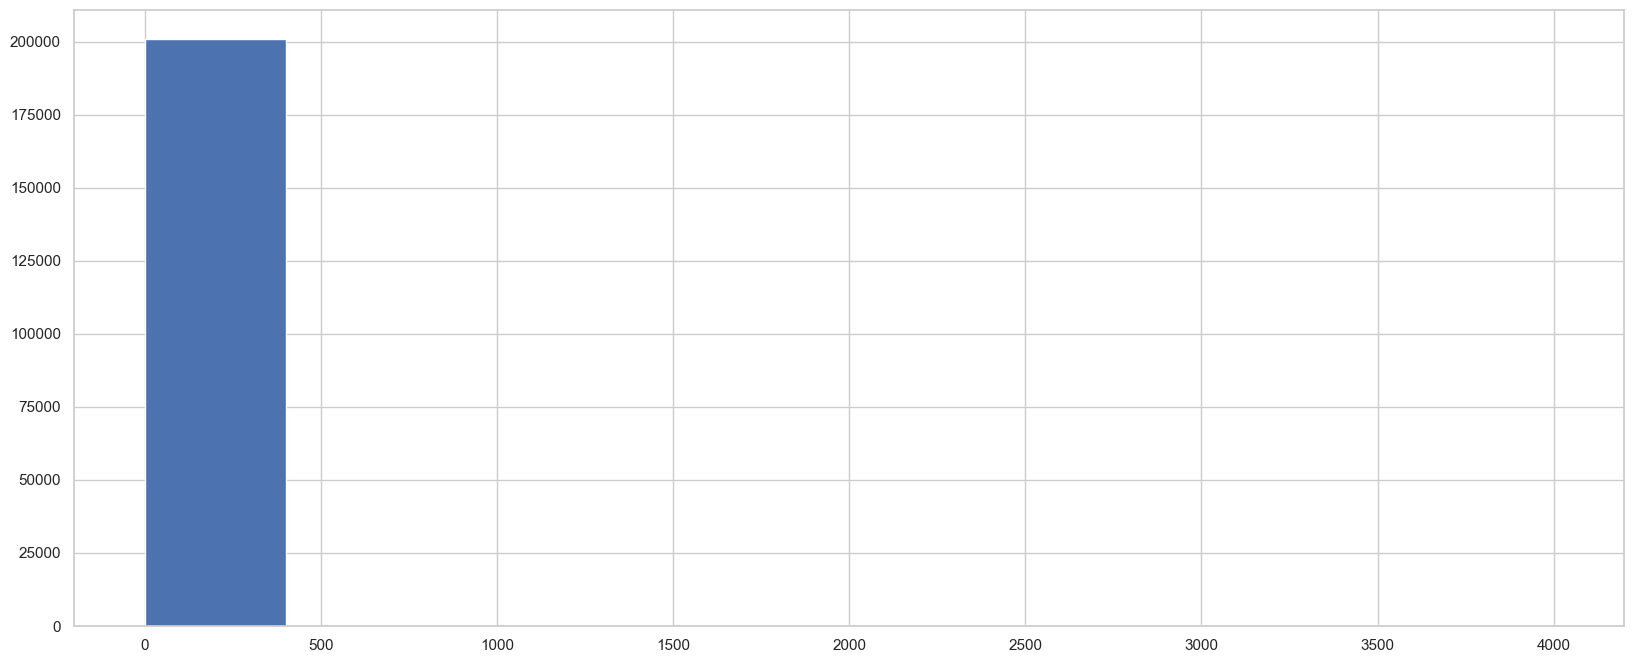

In [27]:
df.query("testgroup == 'b'")['revenue'].hist()


По графику контрольной группы видно, что присутствуют выбросы

Посмотрим на распределение выручки по платящим пользователям:

<Axes: >

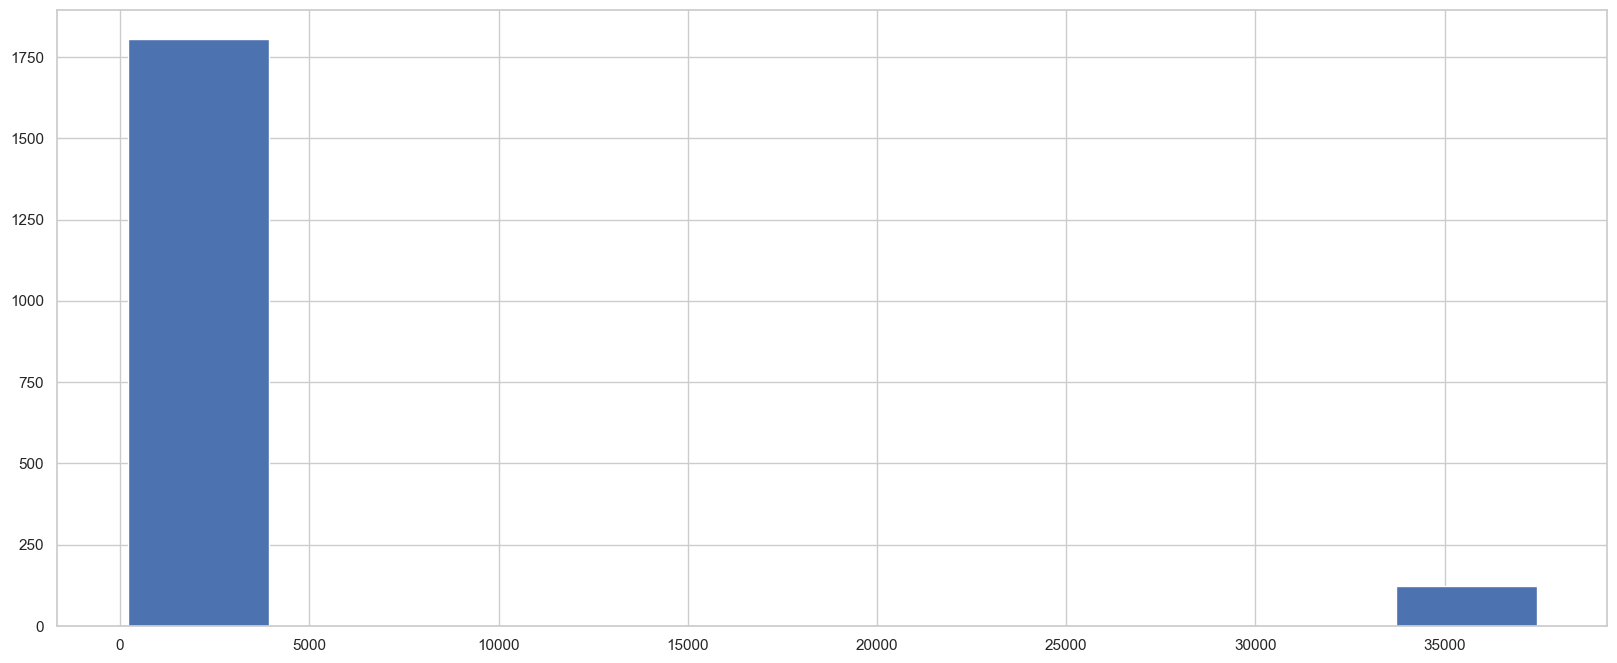

In [28]:
df.query("testgroup == 'a' and revenue >0 ")['revenue'].hist()


<Axes: >

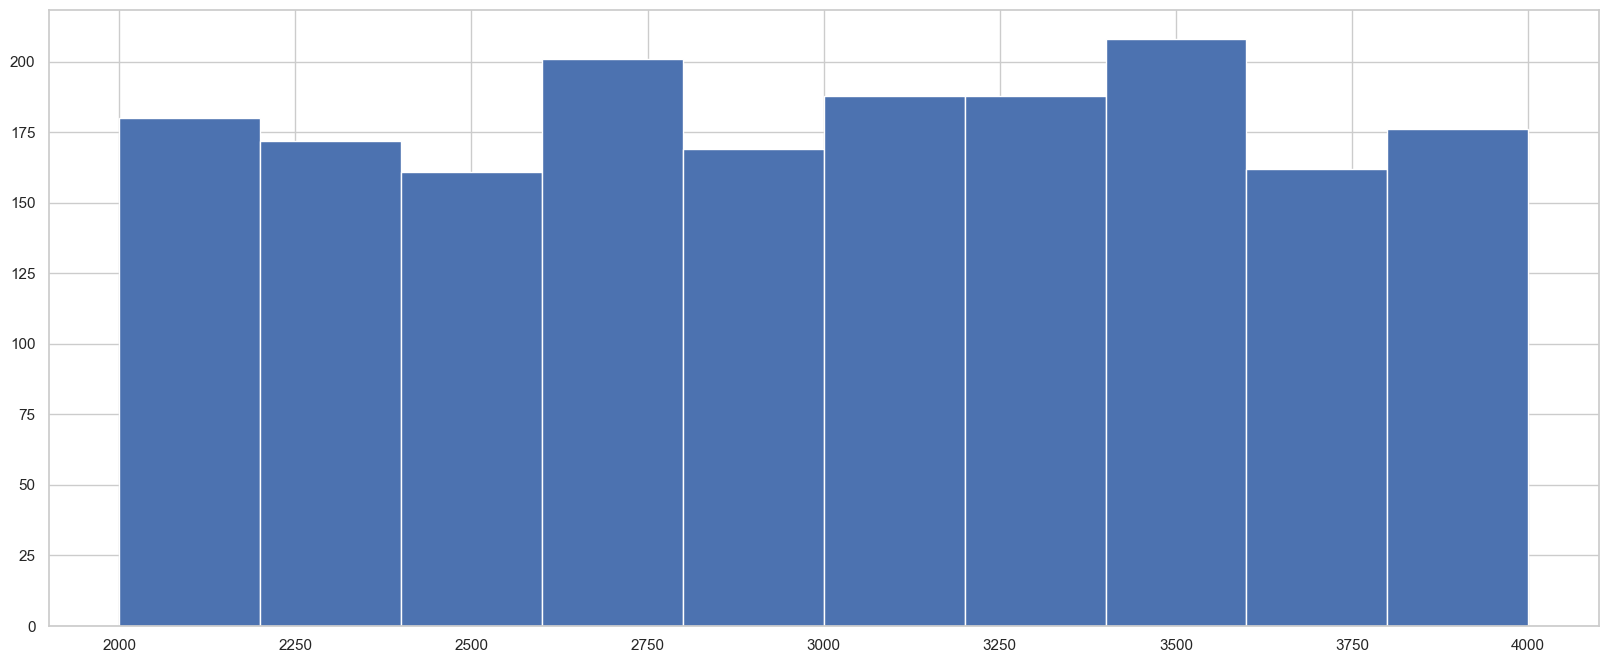

In [29]:
df.query("testgroup == 'b' and revenue > 0 ")['revenue'].hist()


Посмотрим на минимальные и максимальные значения выручки в группах

In [30]:
df.groupby('testgroup',as_index=False).agg({'revenue' :['min', 'max']})


testgroup revenue       
                min    max
0         a       0  37433
1         b       0   4000

В контрольной группе значение максимальной выручки значительно выше, чем в тестовой.

Разобьем выручку на группы и посмотрим как распределились траты пользователей:

In [31]:
a = df.query("testgroup == 'a'")


In [32]:
pd.cut(a['revenue'], [0, 1000, 2000, 3000, 4000, 10000, 20000, 30000, 40000, float('inf')]).value_counts().reset_index()


,index,revenue
0,"(0.0, 1000.0]",1805
1,"(30000.0, 40000.0]",123
2,"(1000.0, 2000.0]",0
3,"(2000.0, 3000.0]",0
4,"(3000.0, 4000.0]",0
5,"(4000.0, 10000.0]",0
6,"(10000.0, 20000.0]",0
7,"(20000.0, 30000.0]",0
8,"(40000.0, inf]",0


In [33]:
b = df.query("testgroup == 'b'")


In [34]:
pd.cut(b['revenue'], [0, 1000, 2000, 3000, 4000, 10000, 20000, 30000, 40000, float('inf')]).value_counts().reset_index()


,index,revenue
0,"(3000.0, 4000.0]",922
1,"(2000.0, 3000.0]",882
2,"(1000.0, 2000.0]",1
3,"(0.0, 1000.0]",0
4,"(4000.0, 10000.0]",0
5,"(10000.0, 20000.0]",0
6,"(20000.0, 30000.0]",0
7,"(30000.0, 40000.0]",0
8,"(40000.0, inf]",0


Траты пользователей распределились:

- Контрольная группа:  1805 клиентов с выручкой интервале от 0 до 1000, но есть 123 клиента с выручкой в интервале от 30000 до 40000

- Тестовая группа:  1 клиент с выручкой в интервале от 1000 до 2000, 882 клиента с выручкой в интервале от 2000 до 3000 и 922 клиента с выручкой в интервале от 3000 до 4000


Еще раз посмотрим на средний чек по платящим пользователям


In [35]:
cnt_client[['testgroup','number_paying_customers','average_check']]


,testgroup,number_paying_customers,average_check
0,a,1928,2664.0
1,b,1805,3004.0


Количество платящих клиентов больше в контрольной группе, но почти все пользователи в сегменте до 1000 и также в контрольной группе присутствует 123 пользователя с крупными тратами в сегменте от 30000 до 40000. 
Тестовая группа за счет более равномерного распределения трат в большем стоимостном интервале имеет более высокий средний чек на платящего пользователя.


Также посмотрим на средний чек по всем пользователям:

In [36]:
df.groupby('testgroup',as_index=False).agg({'revenue' : ['mean', 'median']})


testgroup    revenue       
                  mean median
0         a  25.413720    0.0
1         b  26.751287    0.0

Теперь я хочу проверить гипотезу о равенстве ARPU в тестовой и контрольной группах:



Перед проведением статистических тестов я хочу проверить дисперсии в группах на гомогенность при помощи теста Левена:

- H0 - дисперсии в группах одинаковы
- H1 - дисперсии в группах не одинаковы

In [37]:
group_a = df.query("testgroup == 'a'")


In [38]:
group_b = df.query("testgroup == 'b'")


In [39]:
res = levene(group_a.revenue, group_b.revenue)


In [40]:
f'p-value = {res[1]}'


'p-value = 0.5324948591043842'

- Тест показал, что мы не можем отклонить нулевую гипотезу. Дисперсии в группах одинаковы.

Проверим данные на нормальность:
- H0 - данные имеют нормальное распределение;
- H1 - данные имеют распределение отличное от нормального

In [41]:
pg.normality(data=df, dv="revenue", group="testgroup", method="normaltest")


,W,pval,normal
testgroup,,,
b,326622.395409,0.0,False
a,585152.731273,0.0,False


Мы должны отклонить нулевую гипотезу, данные распределены не нормально

Несмотря на то,что дисперсии в группах одинаковы для проверки гипотезы  равенстве ARPU в группах я буду применять Bootstrap, так как данные распределены не нормально и т-тест может быть не лучшим решением.

- H0 - ARPU в тестовой и контрольной группах отличается статистически не значимо
- H1 - ARPU в тестовой и контрольной группах отличается статистически значимо

In [42]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values

        boot_data.append(statistic(samples_1-samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "quants": quants,
            "p_value": p_value}


  0%|          | 0/1000 [00:00<?, ?it/s]

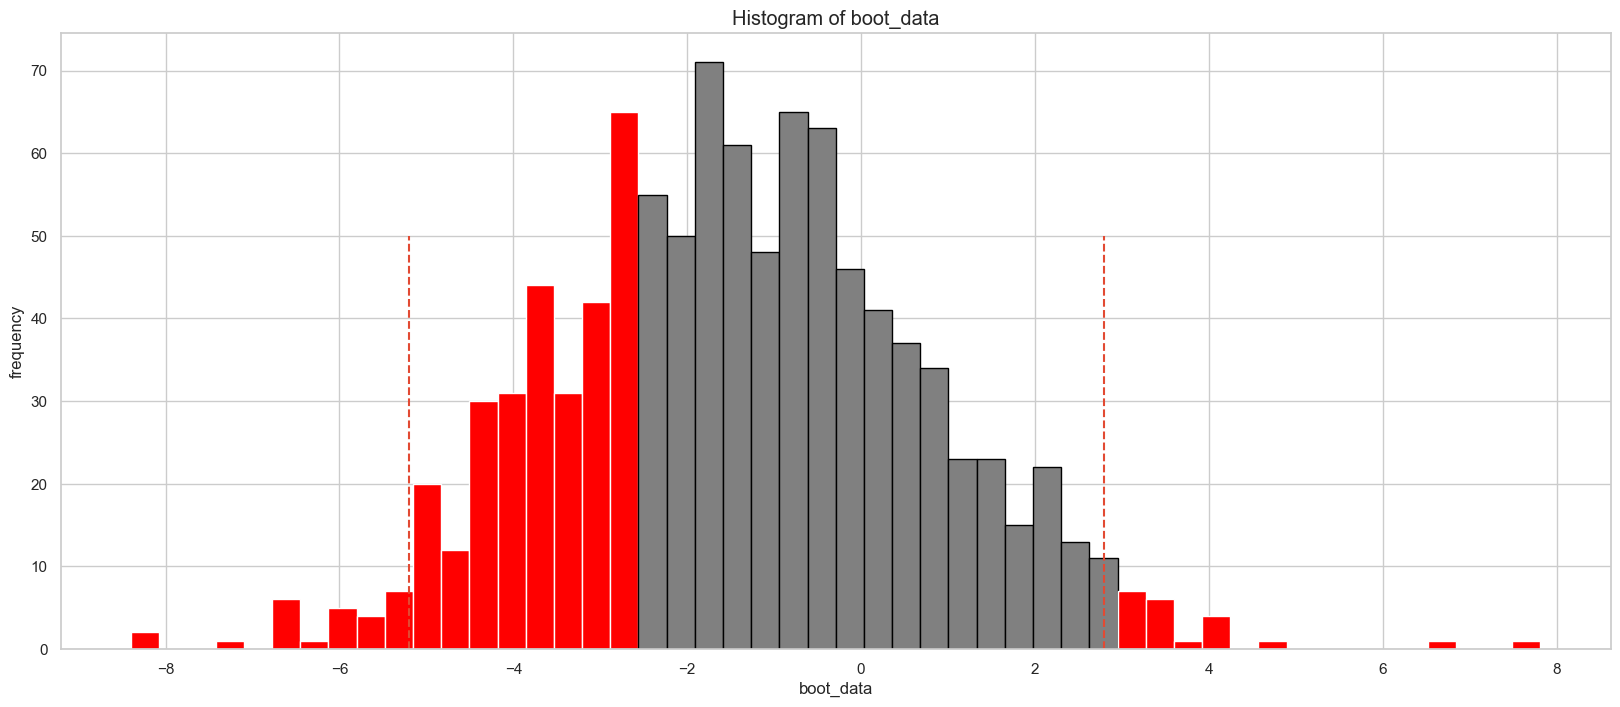

In [43]:
res = get_bootstrap(group_a.revenue,
                    group_b.revenue,
                    boot_it= 1000, #количество бутстреп - подвыборок
                    statistic=np.mean, # интересующая нас статистика
                    bootstrap_conf_level=0.95, #уровень значимости
                    )


In [44]:
x = res['p_value']


In [45]:
f'p-value равен {x}'


'p-value равен 0.509290455916401'

- Тест говорит нам не отклонять нулевую гипотезу

Также я хочу проверить гипотезу о равенстве ARPPU в тестовой и контрольной группах

Но перед этим также проверим дисперсии на гомогенность

In [46]:
res = levene(group_a.query('revenue > 0').revenue, group_b.query('revenue > 0').revenue)


In [47]:
f'p-value = {res[1]}'


'p-value = 3.779689868667878e-19'

- Мы должны отклонить нулевую гипотезу. Дисперсии в группах с платящими пользователями не одинаковы.

Проверим данные на нормальность:

- H0 - данные имеют нормальное распределение;
- H1 - данные имеют распределение отличное от нормального

In [48]:
pg.normality(data=df.query('revenue>0'), dv="revenue", group="testgroup", method="normaltest")


,W,pval,normal
testgroup,,,
a,1394.945784,1.234161e-303,False
b,1068.860008,7.943249e-233,False


Отклоняем нулевую гипотезу. Данные с платящими пользователями распределены не нормально.

Для проверки гипотезы о равенстве ARPPU также будем использовать Bootstrap, так как данные по платящим пользователям распределены не нормально и дисперсии в группах не одинаковы:

- H0 - ARPPU в тестовой и контрольной группах отличается статистически не значимо
- H1 - ARPPU в тестовой и контрольной группах отличается статистически значимо


In [49]:
group_a_paying =  df.query("testgroup == 'a' and revenue > 0")


In [50]:
group_b_paying =  df.query("testgroup == 'b' and revenue > 0")


  0%|          | 0/1000 [00:00<?, ?it/s]

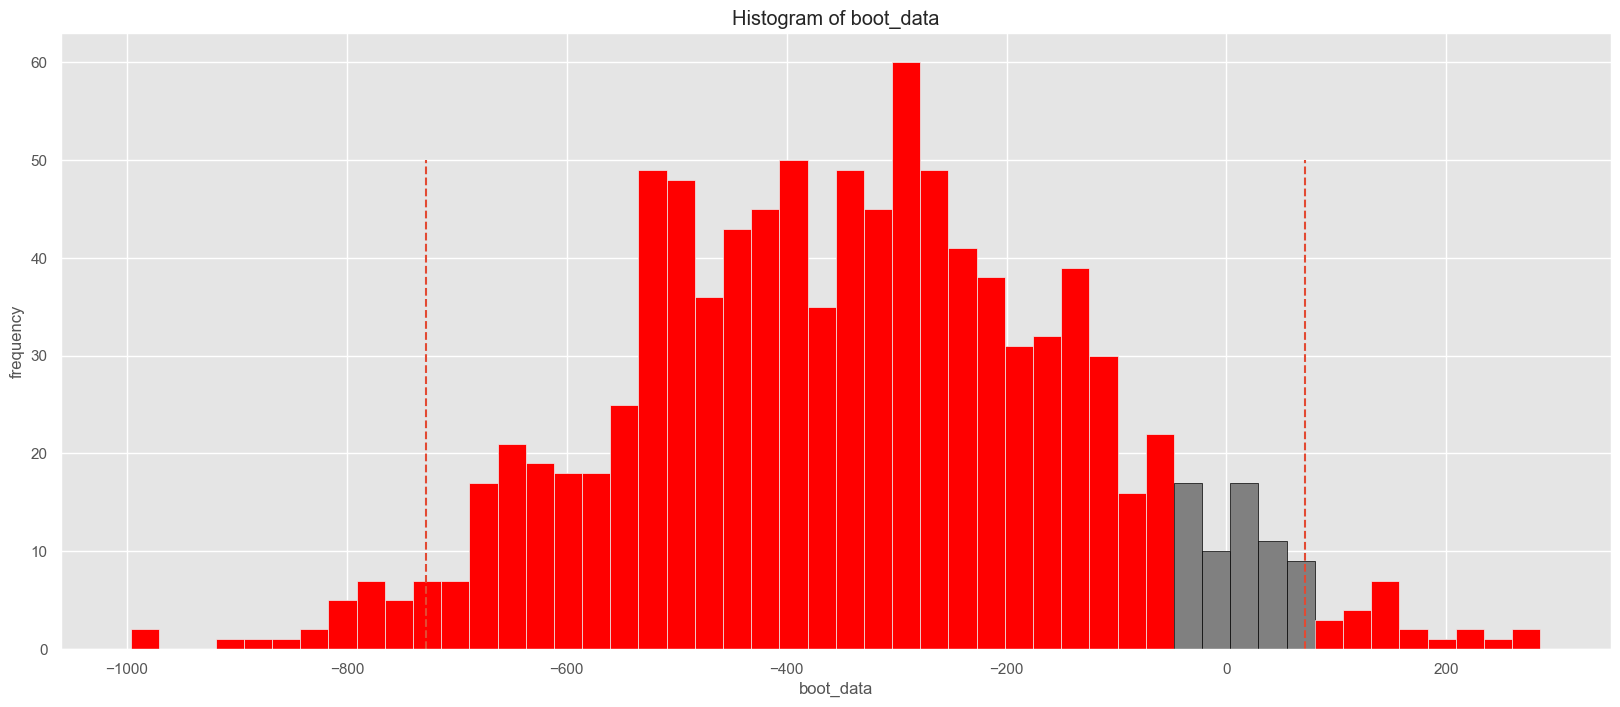

In [51]:
res = get_bootstrap(group_a_paying.revenue,
                    group_b_paying.revenue,
                    boot_it= 1000, #количество бутстреп - подвыборок
                    statistic=np.mean, # интересующая нас статистика
                    bootstrap_conf_level=0.95, #уровень значимости
                    )


In [52]:
x = res['p_value']


In [53]:
f'p-value равен {x}'


'p-value равен 0.105488230788402'

- Тест также говорит нам не отклонять нулевую гипотезу

Выводы:

   Платящих клиентов в контрольной группе больше, чем в тестовой,  конверсия также выше в контрольной группе. Но в контрольной группе присутствуют выбросы - 123 клиента с тратами выше 30000, которые повлияли на распределение трат и исходя из данных не ясно совершаются ли подобные траты постоянно или это разовое событие. В тестовой группе в свою очередь траты пользователей распределены более равномерно и имеют больший стоимостной интервал. Странно, что данные имеют такую разную сегментацию пользователей по тратам.
   
   
- При проверке гипотезы о равенстве ARPU тест показал, что нет оснований отклонить нулевую гипотезу(нет статистически значимых различий);
- При проверке гипотезы о равенстве ARPPU тест также показал, что нет оснований отклонить нулевую гипотезу(нет статистически значимых различий);
- Конверсия в контрольной группе больше -  0.95 в против -  0.89 в тестовой группе. Но исходя из проведенного исследования в тестовой группе у пользователей более дорогие покупки;
- Средней чек по всей выборке в контрольной группе - 25.41, в тестовой группе - 26.75;
- Средний чек по платящим клиентам в контрольной группе - 2664, в тестовой группе - 3004

Ситуация интересная:) Исходя из результатов тестов статистически значимой разницы по ARPU и ARPPU между группами нет. Но мне кажется, что в тестовой группе набор акционных предложений предпочтительнее, потому что пользователи совершали более дорошие покупки и их траты распределены более равномерно.   


Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

 Метрики для первого вопроса:

 Продуктовые метрики:
 - Retention - полезно будет посмотреть вырос ли retention в течение проведения тематического события, также по retention можно увидеть, когда у пользователя начинается период охлаждения к игре;
 - Средняя дневная аудитория - среднее арифметическое дневной аудитории за определенный период. Так мы сможем увидеть вырос ли приток аудитории в связи последними нововведеними;
 - DAU - чтобы оценить работу маркетинга, так как интересно прорекламированный event должен увеличить приток новых пользователей, особенно в первые дни релиза;
 - Conversion Rate - если event окажется интересным и зайдет пользователям, то и конверсия в покупку должна вырасти, особенно если продаваемые улучшения заметно упращают игру
 
 Бизнес метрики:
 - ARPU и ARPPU - по этим метрикам можно оценить насколько правильно реализан платный контент и мотивация к его приобретению, так как может быть ситуация, что новых пользователей мы привлекли, а особого смысла для них приобретать платные улучшения нет, так как они особо и не нужны;
 - CPAcq и САС также необходимо посчитать и сопоставить его с плановыми показателями, чтобы понять оправдал ли ожидания event c материальной точки зрения.
 - CSAT - будет полезно узнать о недоработках, чтобы учесть их будущих ивентах
 

Метрики для второго вопроса:
- Усложнение механики игры очень спорный момент и далеко не всем такое нововедение может зайти, в первую очередь я бы смотрел на обратную связь от пользователей(CSAT), так как это по сути в корне меняет восприятие игры;
- Так как далеко не все пользователи хотят участвовать в опросах нужно смотреть на retention, он покажет хотят ли пользователи возвращаться в игру или новая механика отбила у них желание играть;

Я думаю, с настолько рискованным обновлением остальные метрики из первого вопроса можно отслеживать если только у нас не рухнули первые 2 пункта, так как если пользователям совсем не зашло новвоведение - нужно экстренно что-то менять, потому что есть риск потерять большую часть аудитории.

